In this tutorial notebook, we focus on a specific example of a point cloud, to illustrate how to compute its GPDs using the provided code in the **utils.py** file.

We will show you how to:
- **create** a bifiltration from a given point cloud
- **generate a grid and a specific collection of intervals** on the grid
- **compute Generalized Rank Invariants (GRIs)**, using boundary zigzag filtraions [(Dey, Kim, Memoli 2023)](https://link.springer.com/article/10.1007/s00454-023-00584-z)
- **calculate the Möbius function** of the poset of intervals over which the GPDs are computed

## Setup

All the necessary code for computing GPDs is located in the utils.py file.

In [2]:
import utils
import archive
import numpy as np
import matplotlib.pyplot as plt
from multipers.data import noisy_annulus

## Define a point cloud and create a bifiltration 

The following point cloud consists of 3 points on the annulus, and 2 points on the square. Any point cloud can be an input.

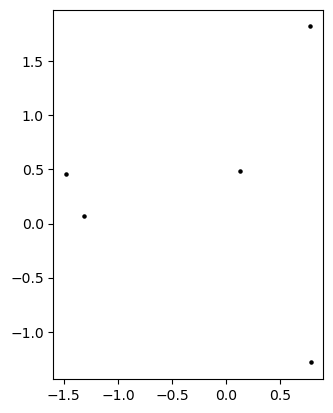

In [3]:
X = noisy_annulus(n1=3, n2=2)
plt.scatter(X[:,0], X[:,1], s=5, c='k');plt.gca().set_aspect(1);

In what follows, we create a bifiltration over $\mathbb{R}^2$ and sample 9 points that forms a 3x3 grid on the plane.

**Note:** the first parameter of the bifiltration is the Rips parameter and the second parameter is the log value of codensity.

For more details, refer to [Multipers documentation](https://www-sop.inria.fr/members/David.Loiseaux/doc/multipers/index.html).

In [4]:
bifiltration = utils.get_bifiltration(X)

grid = utils.get_grid(bifiltration, 3)

print(f'x-coordinates of the grid are {grid[0]}')
print(f'y-coordinates of the grid are {grid[1]}')

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode
x-coordinates of the grid are [0.         1.55207764 3.10415528]
y-coordinates of the grid are [-0.44100055 -0.41997142 -0.39894228]


Now, we generate all **(1, 1)**-intervals and **(2, 1)**-intervals on the grid. 

In [5]:
intervals = utils.get_int_2_1(grid)

To employ the gradient descent method later, we need to ***vectorize*** each interval as follows:

In [6]:
diff_x, diff_y = grid[0][1] - grid[0][0], grid[1][1] - grid[1][0]

intv_to_vec = []
for intv in intervals:
    vector = []

    if len(intv[0]) == 1:
        vector += intv[0][0]
        d, a = intv[1][0][0] - intv[0][0][0], intv[1][0][1] - intv[0][0][1]
        vector += [a + diff_y, 0, 0, d + diff_x]
    else:
        vector += [intv[0][1][0], intv[0][0][1]]
        a, b = intv[1][0][1] - intv[0][0][1], intv[0][1][0] - intv[0][0][0]
        c, d = intv[0][0][1] - intv[0][1][1], intv[1][0][0] - intv[0][1][0]
        vector += [a + diff_y, b, c, d + diff_x]

    intv_to_vec.append(vector)

For example, an interval *before* and *after* vectorization looks like:

In [7]:
before = intervals[0]
print(before)

([(np.float64(0.0), np.float64(-0.4410005538849897))], [(np.float64(0.0), np.float64(-0.4410005538849897))])


In [8]:
after = intv_to_vec[0]
print(after)

[np.float64(0.0), np.float64(-0.4410005538849897), np.float64(0.02102913674177853), 0, 0, np.float64(1.5520776413916824)]


 Then, by Theorem 3.12 in [this paper](https://link.springer.com/article/10.1007/s00454-023-00584-z), we can compute the generalized rank over each interval by counting the number of bars fully supported on its boundary zigzag module.

For our experiments, we use only $d = 0, 1$.

Note that the histogram below represents the distribution of GRI values.

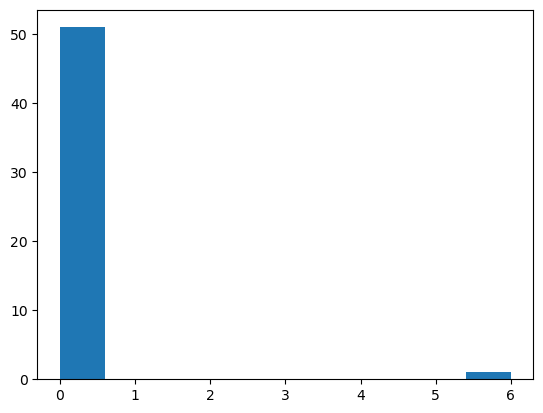

In [7]:
bifil_on_intervals = utils.get_bifil_on_intervals(bifiltration, intv_to_vec)

GRIs = []
for intv in intv_to_vec:
    ZZ_persistence = utils.get_ZZpersistence(bifil_on_intervals, intv, dimension=1)
    gri = utils.count_fullbar(ZZ_persistence)
    GRIs.append(gri)

plt.hist(GRIs)
plt.show()

Simply using the *GRI* function, you can repeat the same process:

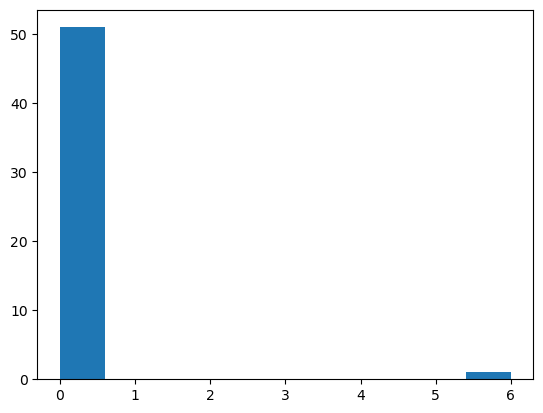

In [8]:
GRIs = []
for intv in intv_to_vec:
    GRIs.append(utils.GRI(bifil_on_intervals, intv, dimension=1))

plt.hist(GRIs)
plt.show()

Next, we calculate the Möbius function of the poset of intervals.

In [9]:
mobius_matrix = utils.mobius_matrix(intv_to_vec)

Finally, we obtain generlized persistence diagrams (GPDs) by computing the Möbius inversion of GRIs.

For the definition of GPDs, refer to [this paper](https://www.ams.org/journals/notices/202308/noti2761/noti2761.html).

Note that in this case, the GPDs are computed over only ***(1, 1)***-intervals and ***(1, 2)***-intervals of the grid, not ***all*** intervals.

One can see the distribution of GPD values as shown in the following figure. 

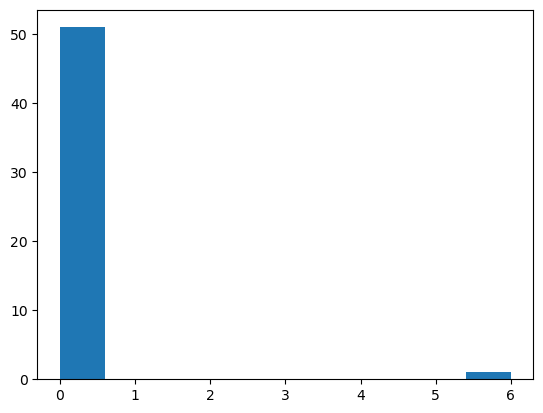

In [10]:
GRIs = np.array(GRIs)

GPDs = np.matmul(mobius_matrix, GRIs)

plt.hist(GPDs)
plt.show()

Or with the *GPD* function, you can calculate the GPDs much easily.

**Caution:** for technical issues related to torch.Tensor, the *GPD* function contains the following code block:
```
intervals = intervals.tolist()
```
Thus, if you work with torch.Tensor, please activate this code block before running the *GPD* function.

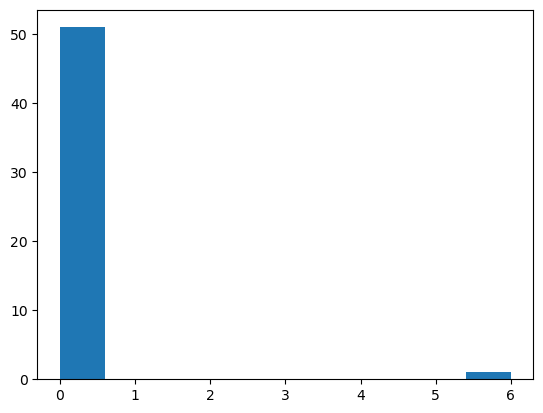

In [12]:
GPDs = utils.GPD(bifiltration, intv_to_vec, dimension=1)

plt.hist(GPDs.values())
plt.show()

## An example of the GPDs containing negative values

In [2]:
grid = [[0, 1, 2], [0, 1, 2]]

bifil_on_grid = {(0, 0): [], (0, 1): [], (0, 2): [(1,)],
                 (1, 0): [], (1, 1): [(2,)], (1, 2): [(1,), (2,)],
                 (2, 0): [], (2, 1): [(2,)], (2, 2): [(1,), (2,), (1, 2)]}

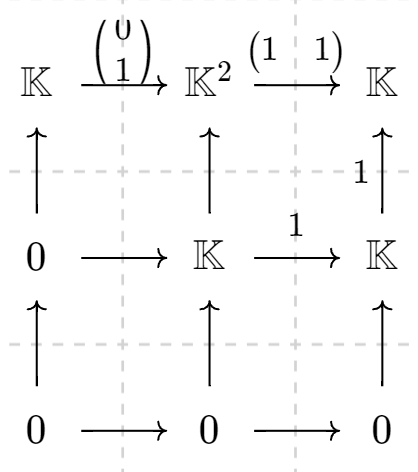

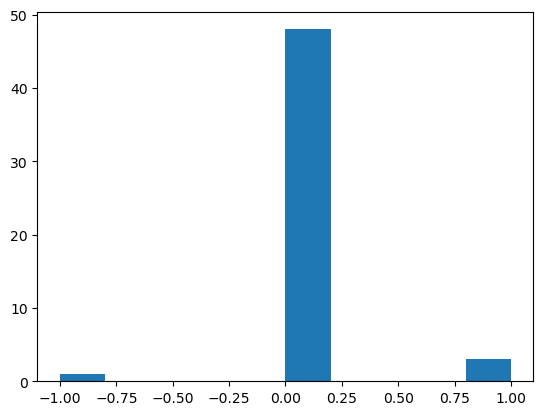

In [21]:
intervals = utils.get_int_2_1(grid)

GRIs = []
for intv in intervals:
    ZZ_persistence = archive.get_ZZpersistence(bifil_on_grid, intv, dimension=0)
    gri = archive.count_fullbar(ZZ_persistence)
    GRIs.append(gri)

mobius_matrix = archive.mobius_matrix(intervals)

GRIs = np.array(GRIs)

GPDs = np.matmul(mobius_matrix, GRIs)

plt.hist(GPDs)
plt.show()

In [22]:
for index, gpd in enumerate(GPDs):
    if gpd:
        print(gpd, index, intervals[index])

1 5 ([(1, 2)], [(1, 2)])
1 31 ([(1, 1)], [(2, 2)])
1 47 ([(0, 2), (2, 1)], [(2, 2)])
-1 51 ([(1, 2), (2, 1)], [(2, 2)])


In [3]:
intervals = utils.get_int_2_1(grid)

# mobius_matrix = archive.mobius_matrix(intervals)

intv_to_vec = []

diff_x, diff_y = grid[0][1] - grid[0][0], grid[1][1] - grid[1][0]
for intv in intervals:
    # GRIs.append(GRI(bifil_on_grid, intv, dimension))
    vector = []

    if len(intv[0]) == 1:
        vector += intv[0][0]
        d, a = intv[1][0][0] - intv[0][0][0], intv[1][0][1] - intv[0][0][1]
        vector += [a + diff_y, 0, 0, d + diff_x]
    else:
        vector += [intv[0][1][0], intv[0][0][1]]
        a, b = intv[1][0][1] - intv[0][0][1], intv[0][1][0] - intv[0][0][0]
        c, d = intv[0][0][1] - intv[0][1][1], intv[1][0][0]- intv[0][1][0]
        vector += [a + diff_y, b, c, d + diff_x]

    intv_to_vec.append(vector)

# GPDs = {tuple(intv): gpd for intv, gpd in zip(intv_to_vec, np.matmul(mobius_matrix, GRIs))}

In [7]:
bifiltration = [((1,), (0, 2)), ((2,), (1, 1)), ((1, 2), (2, 2))]

In [8]:
intervals = intv_to_vec

In [9]:
GPDs = utils.GPD(bifiltration, intervals)

for interval, value in GPDs.items():
    if value:
        print(interval, value)

(1, 1, 2, 0, 0, 2) 1
(2, 2, 1, 2, 1, 1) 1
(2, 2, 1, 1, 1, 1) -1


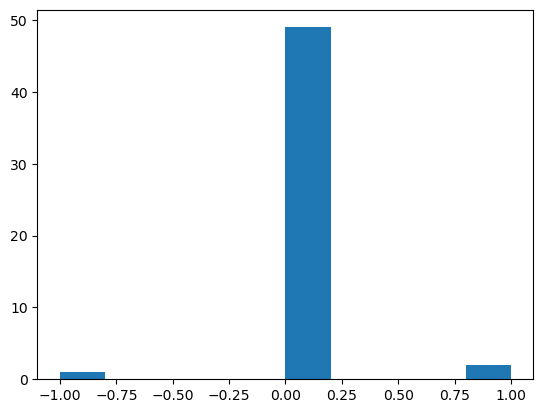

In [10]:
plt.hist(GPDs.values())
plt.show()

In [12]:
intervals = [[0, 0, 1, 0, 0, 1], [-0.5, -0.7, 2, 0, 0, 2], [0, 0, 1, 0, 0, 3], [0, 0, 3, 0, 0, 1],
              [3.1, 3.8, 1, 0, 0, 1], [3, 3, 1.2, 1.3, 1.3, 1.3], [-1, -1, 10.7, 0, 0, 11.5]]

(3.1, 3.8, 1, 0, 0, 1) 1
(3, 3, 1.2, 1.3, 1.3, 1.3) 1


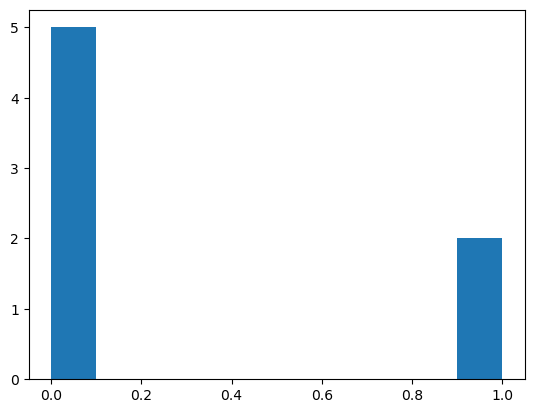

In [13]:
GPDs = utils.GPD(bifiltration, intervals)

for interval, value in GPDs.items():
    if value:
        print(interval, value)

plt.hist(GPDs.values())
plt.show()

In [15]:
poset = utils.generate_poset(intervals)

for i in poset:
    print(i)

[1, 1, 1, 1, 0, 0, 1]
[0, 1, 0, 0, 0, 0, 1]
[0, 0, 1, 0, 0, 0, 1]
[0, 0, 0, 1, 0, 0, 1]
[0, 0, 0, 0, 1, 1, 1]
[0, 0, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 0, 0, 1]


In [17]:
tree = utils.generate_tree(intervals, poset)

In [18]:
for i in tree:
    print(i)

[[], [1, 2, 3]]
[[0], [6]]
[[0], [6]]
[[0], [6]]
[[], [5]]
[[4], [6]]
[[1, 2, 3, 5], []]


In [19]:
mu = utils.mobius_matrix(intervals)

for i in mu:
    print(i)

[1, -1, -1, -1, 0, 0, 2]
[0, 1, 0, 0, 0, 0, -1]
[0, 0, 1, 0, 0, 0, -1]
[0, 0, 0, 1, 0, 0, -1]
[0, 0, 0, 0, 1, -1, 0]
[0, 0, 0, 0, 0, 1, -1]
[0, 0, 0, 0, 0, 0, 1]
